In [96]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import lightgbm as lgb
from matplotlib import pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

from ctgan import CTGAN

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import mlflow
import mlflow.sklearn
import mlflow.xgboost
import matplotlib.pyplot as plt

mlflow.set_tracking_uri("http://localhost:5000")

# Explorative Data Analysis

In [ ]:
# df = pd.read_excel(r'data\flats_to_rent_wue_preprocessed_combined.xlsx')
# profile = ProfileReport(df, title="Flats -  Würzburg - Rent - Overview", explorative=True)
# profile.to_file("eda-wue-rent-all.html")

In [ ]:
# df = pd.read_excel(r'data\houses_to_buy_wue_preprocessed_1207.xlsx')
# profile = ProfileReport(df, title="Houses -  Würzburg - Buy - Overview", explorative=True)
# profile.to_file("eda-wue-houses.html")

# Preprocessing & Feature Engineering


In [ ]:
def determineHighCorrCols(df):
    df.columns = [re.sub(r"\\u([0-9a-fA-F]{4})", lambda m: chr(int(m.group(1), 16)), col) for col in df.columns]
    df.columns = [col.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue").replace("ß", "ss") for col in df.columns]
    important_num_cols = list(df.corr()["Object_price"][(df.corr()["Object_price"]>0.20) | (df.corr()["Object_price"]<-0.20)].index)
    cat_cols = [col for col in df.columns if df[col].dtype == 'object']
    important_cols = important_num_cols + cat_cols +   ["ConstructionYear"] + ["ZipCode"]
    #   df = df[important_cols]
    print(important_cols)
    return important_cols

In [ ]:
def preprocess_data(df, feature_set):
    print(f"Used feature set for preprocessing:{feature_set}")
    df.columns = [
        re.sub(r"\\u([0-9a-fA-F]{4})", lambda m: chr(int(m.group(1), 16)), col)
        for col in df.columns
    ]
    df.columns = [
        col.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue").replace("ß", "ss")
        for col in df.columns
    ]

    df = df.replace('""', np.nan)
    df = df.dropna()
    df["LivingSpace"] = df["LivingSpace"].astype(float)
    df["Rooms"] = df["Rooms"].astype(float)
    # df = df.dropna(subset=["ConstructionYear"])
    # df = df.dropna(subset=["Object_price"])
    # df = df.dropna(subset=["Rooms"])
    # df = df.dropna(subset=["LivingSpace"])
    df["ZipCode"] = df["ZipCode"].astype(str)
    df["LivingSpace"] = df["LivingSpace"].astype(float)
    df = df[feature_set]
    df = df.reindex()
    df = df.reset_index(drop=True)

    # one-hot encoding
    cat_cols = [col for col in df.columns if df[col].dtype == "object"]
    y = df["Object_price"]
    X = df.drop("Object_price", axis=1)
    X = pd.get_dummies(X, columns=cat_cols)

    return X, y

# Data Split


In [ ]:
def data_split(X, y, train_size=0.8, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=random_state
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, train_size=train_size, random_state=random_state
    )

    # X_train.to_excel("data/X_train.xlsx")
    # X_val.to_excel("data/X_val.xlsx")
    # X_test.to_excel("data/X_test.xlsx")
    # y_train.to_excel("data/y_train.xlsx")
    # y_val.to_excel("data/y_val.xlsx")
    # y_test.to_excel("data/y_test.xlsx")

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
df = pd.read_excel(r"data\flats_to_rent_wue_preprocessed_combined.xlsx")

X = df.drop("Object_price", axis=1)
y = df["Object_price"]

data_split(X, y)

# Training, Evaluation and Logging Of Models

## Baseline 

In [ ]:
def scrape_avg_rental_prices():
    url = "https://www.wohnungsboerse.net/mietspiegel-Wuerzburg/2772"
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    script_tag = soup.find("script", string=lambda text: "pdfData" in text)
    rental_price = 0
    if script_tag:
        script_content = script_tag.string
        start_index = script_content.find("avg_rent_price: ") + len("avg_rent_price: '")
        end_index = script_content.find("',", start_index)
        rental_price = script_content[start_index:end_index]
        rental_price = (
            rental_price.replace("€/m2", "").replace(".", "").replace(",", ".")
        )
        rental_price = rental_price.strip()
        rental_price = float(rental_price)
        print(f"Extrcated rental price per square meter via scraper: {rental_price}")
    else:
        print("The script tag containing the rental price was not found.")
    return rental_price

In [ ]:
def scrape_avg_buy_prices():
    url = "https://www.wohnungsboerse.net/immobilienpreise-Wuerzburg/2772"
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    p_element = soup.find("p", class_="mb-8")
    buy_price = 0
    if p_element:
        pattern = r"\d{1,3}(?:\.\d{3})*(?:,\d{2})?€/m²"
        match = re.search(pattern, p_element.text)
        if match:
            buy_price = match.group()
            buy_price = buy_price.replace("€/m²", "").replace(".", "").replace(",", ".")
            print(f"Extrcated buy price per square meter via scraper: {buy_price}")
        else:
            print("Price not found")
    else:
        print("The element ontaining the buy price was not found.")
    return buy_price

In [ ]:
def baseline_rent(val_X, val_y, runname="baseline_rent"):
    avg_price_per_sqm_rent = scrape_avg_rental_prices()
    print(f"Average rental price per sqm: {avg_price_per_sqm_rent}")
    baseline_preds = val_X["LivingSpace"] * avg_price_per_sqm_rent
    baseline_mae = mean_absolute_error(val_y, baseline_preds)
    baseline_r2 = r2_score(val_y, baseline_preds)
    baseline_mse = mean_squared_error(val_y, baseline_preds)

    with mlflow.start_run(run_name=runname):
        mlflow.log_metric("mse", baseline_mse)
        mlflow.log_metric("mae", baseline_mae)
        mlflow.log_metric("r2", baseline_r2)

    print(f"Baseline Mae: {baseline_mae}")
    print(f"Baseline MSE: {baseline_mse}")
    print(f"Baseline R2 Score: {baseline_r2}")
    return avg_price_per_sqm_rent, baseline_mae, baseline_mse, baseline_r2

In [ ]:
def baseline_buy(X_val, y_val, runname="baseline_buy"):
    avg_price_per_sqm_buy = scrape_avg_buy_prices()
    print(f"Average rental price per sqm: {avg_price_per_sqm_buy}")

    baseline_preds = X_val["LivingSpace"] * avg_price_per_sqm_buy
    baseline_mae = mean_absolute_error(y_val, baseline_preds)
    baseline_r2 = r2_score(y_val, baseline_preds)
    baseline_mse = mean_squared_error(y_val, baseline_preds)

    with mlflow.start_run(run_name=runname):
        mlflow.log_metric("mse", baseline_mse)
        mlflow.log_metric("mae", baseline_mae)
        mlflow.log_metric("r2", baseline_r2)

    print(f"Baseline Mae: {baseline_mae}")
    print(f"Baseline MSE: {baseline_mse}")
    print(f"Baseline R2 Score: {baseline_r2}")

    return avg_price_per_sqm_buy, baseline_mae, baseline_mse, baseline_r2

## Linear Regression

In [ ]:
def train_and_eval_linear(X_train, y_train, X_val, y_val, runname="linear-regression"):
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name=runname):
        model = LinearRegression()
        model.fit(X_train, y_train)

        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)

        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        mlflow.log_metric("mae", mae_train)
        mlflow.log_metric("mse", mse_train)
        mlflow.log_metric("r2", r2_train)
    return model, mae, mse, r2, mae_train, mse_train, r2_train

## Lasso Regression

In [ ]:
def train_and_eval_lasso(X_train, y_train, X_val, y_val, runname="lasso-regression"):
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name=runname):
        model = Lasso()
        model.fit(X_train, y_train)

        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)

        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        mlflow.log_metric("mae", mae_train)
        mlflow.log_metric("mse", mse_train)
        mlflow.log_metric("r2", r2_train)
    return model, mae, mse, r2, mae_train, mse_train, r2_train

## Ridge Regression

In [ ]:
def train_and_eval_ridge(X_train, y_train, X_val, y_val, runname="ridge-regression"):
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name=runname):
        model = Ridge()
        model.fit(X_train, y_train)

        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)

        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        mlflow.log_metric("mae", mae_train)
        mlflow.log_metric("mse", mse_train)
        mlflow.log_metric("r2", r2_train)
    return model, mae, mse, r2, mae_train, mse_train, r2_train

## Random Forest

In [ ]:
def train_and_eval_rf(
    X_train,
    y_train,
    X_val,
    y_val,
    n_estimators=50,
    random_state=0,
    run_name="random-forest",
):
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name=run_name):
        model = RandomForestRegressor(
            n_estimators=n_estimators, random_state=random_state
        )
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mse = mean_squared_error(y_val, preds)
        r2 = r2_score(y_val, preds)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)
        return model, mae, mse, r2, mae_train, mse_train, r2_train

## XGBRegressor


In [ ]:
def train_and_eval_xgb(
    X_train,
    y_train,
    X_val,
    y_val,
    run_name="xgb",
    early_stopping_rounds=30,
    max_depth=6,
    n_estimators=1000,
):
    mlflow.xgboost.autolog()
    with mlflow.start_run(run_name=run_name):
        model = xgb.XGBRegressor(
            eval_metric=["rmse", "mae"],
            early_stopping_rounds=early_stopping_rounds,
            random_state=42,
            max_depth=max_depth,
            n_estimators=n_estimators,
        )
        mlflow.log_param("early_stopping_rounds", early_stopping_rounds)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("n_estimators", n_estimators)
        model.fit(X=X_train, y=y_train, eval_set=[(X_val, y_val)], verbose=True)
        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mse = mean_squared_error(y_val, preds)
        r2 = r2_score(y_val, preds)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("r2", r2)
        return model, mae, mse, r2, mae_train, mse_train, r2_train

## ElasticNet

In [ ]:
def train_and_eval_elasticnet(X_train, y_train, X_val, y_val, runname="elasticNet"):
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name=runname):
        model = ElasticNet()
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        mae_train = mean_absolute_error(y_train, pred_train)
        mse_train = mean_squared_error(y_train, pred_train)
        r2_train = r2_score(y_train, pred_train)
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mse = mean_squared_error(y_val, preds)
        r2 = r2_score(y_val, preds)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("r2_train", r2_train)
        return model, mae, mse, r2, mae_train, mse_train, r2_train

# Complete Pipeline

### Regular Pipeline

In [ ]:
def pipeline_from_extracted(df, feature_set, model_name="lasso"):
    X, y = preprocess_data(df, feature_set)
    print("Done with preprocessing")
    X_train, y_train, X_val, y_val, test_X, test_y = data_split(X, y)
    print("Done with data split")

    model, mae, mse, r2, mae_train, mse_train, r2_train = (
        None,
        None,
        None,
        None,
        None,
        None,
        None,
    )

    if model_name == "lasso":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_lasso(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "ridge":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_ridge(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "rf":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_rf(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "xgb":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_xgb(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "elasticnet":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_elasticnet(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "linear":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_linear(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "baseline-rent":
        avg_price, mae, mse, r2 = baseline_rent(X_val, y_val)
    else:
        print(
            "Model not found. Model_name must be 'lasso', 'ridge', 'rf', 'xgb', 'elasticnet', 'linear', 'baseline_buy' or 'baseline_rent'"
        )
    print("Done with train")
    return model, mae, mse, r2, mae_train, mse_train, r2_train

### Augmented Data Approach with CTGan

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.autolog(disable=True)
def complete_from_extracted_with_augemented_training_data(
    df,
    feature_set,
    model_name,
    augmentation_epochs=30,
    n_added_fake_train_data=1000,
):
    df = pd.read_excel(r"data\flats_to_rent_wue_preprocessed_combined.xlsx")
  

    df = df.replace('""', np.nan)
    df = df.dropna()
    df["LivingSpace"] = df["LivingSpace"].astype(float)
    df["Rooms"] = df["Rooms"].astype(float)
    # df = df.dropna(subset=["ConstructionYear"])
    # df = df.dropna(subset=["Object_price"])
    # df = df.dropna(subset=["Rooms"])
    # df = df.dropna(subset=["LivingSpace"])
    df["ZipCode"] = df["ZipCode"].astype(str)
    df["LivingSpace"] = df["LivingSpace"].astype(float)
    df = df[feature_set]
    df = df.reindex()
    df = df.reset_index(drop=True)
    X = df.drop(columns=["Object_price"])
    y = df["Object_price"]

    X_train, y_train, X_val, y_val, X_test, y_test = data_split(X, y)
    
    train = pd.concat(
        [X_train, y_train], axis=1
    )
    val = pd.concat(
        [X_val, y_val], axis=1
    )
    
    df_cttrain = train.copy()
    df_cttrain = df_cttrain.dropna()

    numerical_features = ["Rooms", "LivingSpace", "Object_price"]

    df_cttrain[numerical_features] = df_cttrain[numerical_features].astype("int64")
    categorical_features = [
        col for col in df_cttrain.columns if col not in numerical_features
    ]
    ctgan = CTGAN(verbose=True)
    ctgan.fit(df_cttrain, categorical_features, epochs=augmentation_epochs)

    samples = ctgan.sample(n_added_fake_train_data * 3)
    samples["Object_price"] = samples["Object_price"].clip(lower=0)
    samples = samples[samples["LivingSpace"] > 20]
    samples = samples[samples["Object_price"] > 120]
    samples = samples.head(n_added_fake_train_data)

    X_sample_train = samples.drop(columns=["Object_price"])
    y_sample_train = samples["Object_price"]
    X_train = pd.concat([X_train, X_sample_train])
    y_train = pd.concat([y_train, y_sample_train])

    # train_extended = pd.concat(
    #     [X_train, y_train], axis=1
    # )

    # X_train, y_train = preprocess_data(train_extended, feature_set_selected)
    # X_val, y_val = preprocess_data(val, feature_set_selected)

    X_train_cat_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
    X_train = pd.get_dummies(X_train, columns=X_train_cat_cols)


    X_val_cat_cols = [col for col in X_val.columns if X_val[col].dtype == "object"]
    X_val = pd.get_dummies(X_val, columns=X_val_cat_cols)



    print(f"X_val shape: {X_val.shape}")
    print(f"val shape: {val.shape}")
    print(f"X_val head: {X_train.head()}")
    print(f"val head: {val.head()}")

    X_train, X_val = X_train.align(X_val, join="outer", axis=1, fill_value=0)

    model, mae, mse, r2, mae_train, mse_train, r2_train = (
        None,
        None,
        None,
        None,
        None,
        None,
        None,
    )

    if model_name == "lasso":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_lasso(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "ridge":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_ridge(
            X_train,
            y_train,
            X_val,
            y_val,
        )
    elif model_name == "rf":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_rf(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "xgb":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_xgb(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "elasticnet":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_elasticnet(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "linear":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_linear(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "baseline-rent":
        avg_price, mae, mse, r2 = baseline_rent(X_val, y_val)
    else:
        print(
            "Model not found. Model_name must be 'lasso', 'ridge', 'rf', 'xgb', 'elasticnet', 'linear', 'baseline_buy' or 'baseline_rent'"
        )
    print("Done with train")
    return model, mae, mse, r2, mae_train, mse_train, r2_train

# Execution of complete pipeline

In [ ]:
df = pd.read_excel(r'data\flats_to_rent_wue_preprocessed_combined.xlsx')
feature_set_high_corr = determineHighCorrCols(df) + ["ZipCode"]

In [ ]:
mlflow.set_experiment("wue-rent-selected-features-aug-0")
model_names = ['lasso', 'ridge', 'rf', 'xgb', 'elasticnet', 'linear', 'baseline-rent']

feature_set_selected = [
    "Object_price",
    "LivingSpace",
    "ZipCode", 
    "Rooms",
    "altbau_(bis_1945)",
    "balkon",
    "barriefrei",
    "dachgeschoss",
    "einbaukueche",
    "neubau",
    "parkett",
    "stellplatz", 
    "bad/wc_getrennt",
    "personenaufzug",
    "garten",
    "garage",
    "renoviert", 
    "terrasse", 
    "wanne", 
    "zentralheizung",
    "abstellraum",
    "ferne",
    "fussbodenheizung",
    "gartennutzung",
    "kelleranteil"
]

df = pd.read_excel(r'data\flats_to_rent_wue_preprocessed_combined.xlsx')
    
# for model_name in model_names:
#     df = pd.read_excel(r'data\flats_to_rent_wue_preprocessed_combined.xlsx')
#     print("Starting with model: ", model_name)
#     pipeline_from_extracted(df, model_name=model_name, feature_set=feature_set_selected)
#     print("Done with model: ", model_name)
#     print("--------------------------------------------------------")

n_added_fake_train_data = 120

for model_name in model_names:
    df = pd.read_excel(r'data\flats_to_rent_wue_preprocessed_combined.xlsx')
    print("Starting with model: ", model_name)
    complete_from_extracted_with_augemented_training_data(df, model_name=model_name, feature_set=feature_set_selected, n_added_fake_train_data=0)
    print("Done with model: ", model_name)
    print("--------------------------------------------------------")

In [ ]:
# df = pd.read_excel(r"data\flats_to_rent_wue_preprocessed_combined.xlsx")
# complete_from_extracted_with_augemented_training_data(df, feature_set_selected, model_name="lasso", augmentation_epochs=20, n_added_fake_train_data=1000)

## Get all runs and make result plots

In [101]:
results_selected_features = mlflow.search_runs(experiment_names=["wue-rent-selected-features"])
results_selected_features = results_selected_features[["tags.mlflow.runName","metrics.mae","metrics.r2"]]
results_selected_features = results_selected_features.sort_values(by="metrics.mae", ascending=False)
results_selected_features["experiment"] = "wue-rent-selected-features"

results_selected_features_aug_50 = mlflow.search_runs(experiment_names=["wue-rent-selected-features-aug-50"])
results_selected_features_aug_50 = results_selected_features_aug_50[["tags.mlflow.runName","metrics.mae","metrics.r2"]]
results_selected_features_aug_50 = results_selected_features_aug_50.sort_values(by="metrics.mae", ascending=False)
results_selected_features_aug_50["experiment"] = "wue-rent-selected-features-aug-50"

results_selected_features_aug_120 = mlflow.search_runs(experiment_names=["wue-rent-selected-features-aug-120"])
results_selected_features_aug_120 = results_selected_features_aug_120[["tags.mlflow.runName","metrics.mae","metrics.r2"]]
results_selected_features_aug_120 = results_selected_features_aug_120.sort_values(by="metrics.mae", ascending=False)
results_selected_features_aug_120["experiment"] = "wue-rent-selected-features-aug-120"

results_selected_features_aug_1000 = mlflow.search_runs(experiment_names=["wue-rent-selected-features-aug-1000"])
results_selected_features_aug_1000 = results_selected_features_aug_1000[["tags.mlflow.runName","metrics.mae","metrics.r2"]]
results_selected_features_aug_1000 = results_selected_features_aug_1000.sort_values(by="metrics.mae", ascending=False)
results_selected_features_aug_1000["experiment"] = "results-selected-features-aug-1000"

results_selected_features_aug_comparison = pd.concat([results_selected_features_aug_50, results_selected_features_aug_120, results_selected_features_aug_1000])
results_selected_features_aug_comparison.to_excel("results-selected-features-aug.xlsx")
print(results.head(20))

  tags.mlflow.runName  metrics.mae  metrics.r2  \
0       baseline_rent   285.556400    0.580289   
2          elasticNet   231.958821    0.724565   
3                 xgb   212.349642    0.732313   
4       random-forest   194.380348    0.745000   
6    lasso-regression   128.914193    0.889057   
5    ridge-regression   127.370784    0.889534   
1   linear-regression   120.690395    0.896594   
5    ridge-regression   374.394069    0.299214   
1   linear-regression   324.817498    0.363243   
3                 xgb   308.035448    0.374843   
0       baseline_rent   285.556400    0.580289   
6    lasso-regression   277.571682    0.391028   
4       random-forest   268.368859    0.671737   
2          elasticNet   258.430816    0.636040   

                           experiment  
0          wue-rent-selected-features  
2          wue-rent-selected-features  
3          wue-rent-selected-features  
4          wue-rent-selected-features  
6          wue-rent-selected-features  
5        

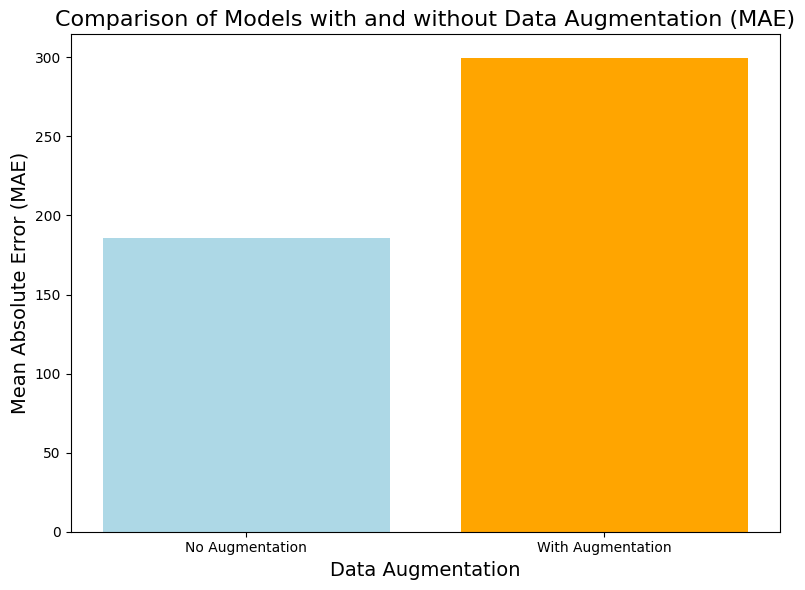

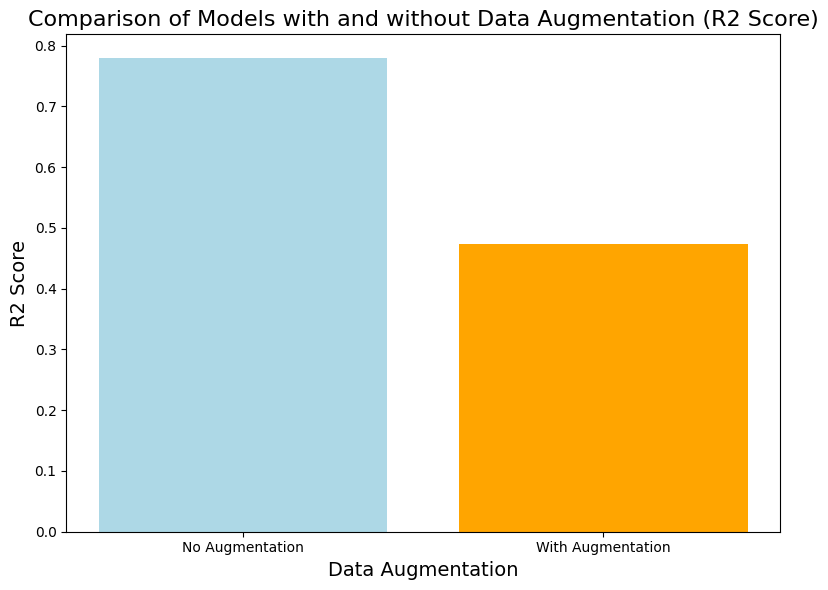

In [95]:
mae_no_aug = results_selected_features["metrics.mae"].mean()
mae_aug_50 = results_selected_features_aug_50["metrics.mae"].mean()
mae_aug_120 = results_selected_features_aug_120["metrics.mae"].mean()
mae_aug_1000 = results_selected_features_aug_1000["metrics.mae"].mean()

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(["No Augmentation", "With Augmentation"], [mae_no_aug, mae_aug], color=["lightblue", "orange"])
ax.set_xlabel("Data Augmentation", fontsize=14)
ax.set_ylabel("Mean Absolute Error (MAE)", fontsize=14)
ax.set_title("Comparison of Models with and without Data Augmentation (MAE)", fontsize=16)
plt.tight_layout()
plt.show()
fig.savefig("impact_of_data_augementation_mae.png")

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(["No Augmentation", "With Augmentation"], [r2_no_aug, r2_aug], color=["lightblue", "orange"])
ax.set_xlabel("Data Augmentation", fontsize=14)
ax.set_ylabel("R2 Score", fontsize=14)
ax.set_title("Comparison of Models with and without Data Augmentation (R2 Score)", fontsize=16)
plt.tight_layout()
plt.show()
fig.savefig("impact_of_data_augementation_r2.png")

